In [1]:
%load_ext autoreload
%autoreload 1
%aimport beanmachine.ppl

From PRML Section 10.2.6

In [79]:
import beanmachine.ppl as bm
from beanmachine.ppl.distributions import Flat
import torch
import torch.distributions as dist
import torch.nn.functional as F

K = 2

@bm.random_variable
def mu(k: int):
    return Flat()

@bm.random_variable
def sigma(k: int):
    return Flat()

@bm.random_variable
def mixture_probs():
    return dist.Dirichlet(0.5*torch.ones(K))

@bm.random_variable
def cluster_assignment(i: int):
    return dist.Categorical(probs=mixture_probs())

@bm.random_variable
def x(i: int):
    k = cluster_assignment(i).int().item()
    return dist.Normal(mu(k), F.softplus(sigma(k)))

In [91]:
true_dist = dist.MixtureSameFamily(
    dist.Categorical(torch.tensor([0.4, 0.6])),
    dist.Normal(1*torch.tensor([-1., 1.]), 0.1*torch.tensor([1., 1.])),
)
N = 20
X = true_dist.sample((N,))

<AxesSubplot:ylabel='Frequency'>

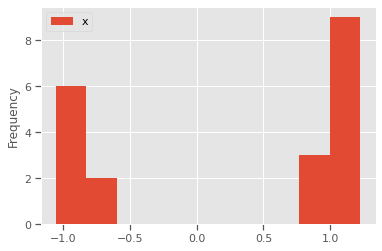

In [92]:
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import pandas as pd

fig, ax = plt.subplots(1,1)
pd.DataFrame({'x': X}).plot(kind='hist', ax=ax)

In [127]:
@bm.param
def r(i: int):
    return torch.rand((K,))*4-2

@bm.random_variable
def q_cluster_assignment(i: int):
    return dist.Categorical(logits=r(i))

@bm.param
def mu_loc():
    return torch.tensor([-2., 2.])

@bm.param
def mu_scale():
    return 0.1*torch.ones((K,))

@bm.random_variable
def q_mu(k: int):
    return dist.Normal(loc=mu_loc()[k], scale=F.softplus(mu_scale()[k]))

@bm.param
def sigma_loc():
    return torch.rand((K,))*4-2

@bm.param
def sigma_scale():
    return 0.1*torch.rand((K,))+0.01

@bm.random_variable
def q_sigma(k: int):
    return dist.Normal(loc=sigma_loc()[k], scale=F.softplus(sigma_scale()[k]))


We have to use the score function / REINFORCE estimator here since the cluster assignment is discrete so there is no gradient with respect to variational parameters

In [128]:
%autoreload

In [170]:
import torch.optim as optim
from tqdm.auto import tqdm


vi = bm.VariationalInfer(
    queries_to_guides={
        mu(k): q_mu(k) for k in range(K)
    } | {
        sigma(k): q_sigma(k) for k in range(K)
    } | {
        cluster_assignment(i): q_cluster_assignment(i) for i in range(N)
    },
    observations={x(i): X[i] for i in range(N)},
    optimizer=lambda params: optim.Adam(params, lr=1e-1),
)



num_steps = 100
losses = torch.empty(num_steps)
log_probs = torch.empty(num_steps)
for i in tqdm(range(num_steps)):
    loss, _ = vi.step(
        mc_approx=bm.inference.variational.variational_infer.monte_carlo_approximate_sf,
        num_samples=2,
    )
    losses[i] = loss

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

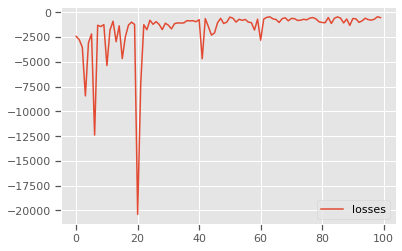

In [171]:
import pandas as pd

pd.DataFrame({
    'losses': losses.detach().numpy(),
}).plot(kind='line')

In [172]:
[vi._world._run_node(q_mu(k)) for k in range(2)]

[(Normal(loc: -0.9476402997970581, scale: 0.6991487145423889), set()),
 (Normal(loc: 2.149923086166382, scale: 1.2238078117370605), set())]

(0.0, 1.0)

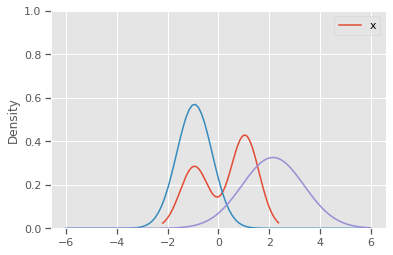

In [173]:
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np

fig, ax = plt.subplots(1,1)
pd.DataFrame({'x': X}).plot(kind='kde', ax=ax)

xs = np.linspace(-6, 6, num=100)
for k in range(K):
    ax.plot(xs, vi._world._run_node(q_mu(k))[0].log_prob(torch.tensor(xs)).exp().detach().numpy())

ax.set_ylim([0, 1])

<AxesSubplot:xlabel='x', ylabel='r'>

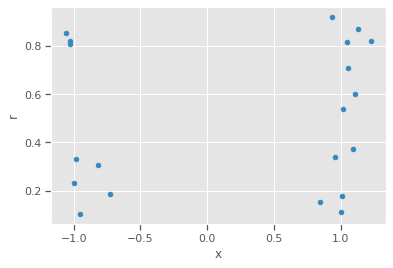

In [174]:
import seaborn as sns; sns.set_context('notebook')

pd.DataFrame({
    'x': X,
    'r': [vi._world._run_node(q_cluster_assignment(i))[0].probs[1].detach() for i in range(N)],
}).plot(kind='scatter', x='x', y='r')